In [1]:
from tqdm import tqdm
from functools import partial
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.func import vmap, grad, functional_call

In [2]:
torch.random.manual_seed(42);

# Meta-learning with Hypernets
Let us consider a toy meta learning example taken from the MAML paper: regression of sinusoidal data with randomized amplitude and phases.

In [3]:
# lower and upper bounds for the sinusoidal dataset parameters
xl = -5.0
xu = 5.0
al = 0.1
au = 0.5
pl = 0.0
pu = 2 * torch.pi

In [4]:
K = 5 # K-shot regression
batch_size = 32 # meta batch size for MAML

Let us define the synthetic dataset distribution

In [5]:
def sample_datasets(batch_size, K, noise_std=0.0, return_params=False):

    """
    Sample a batch of tasks from the sine function with random phases and amplitudes.
    Each task is defined by a different amplitude and phase shift.
    """
    
    amplitudes = torch.FloatTensor(batch_size).uniform_(al, au)
    phases = torch.FloatTensor(batch_size).uniform_(pl, pu)
    batch_x = torch.FloatTensor(batch_size, K).uniform_(xl, xu)
    batch_y = amplitudes[:, None] * torch.sin(batch_x + phases[:, None])
    batch_y += torch.randn(batch_y.shape) * noise_std  # Add noise

    batch_x = batch_x[..., None]
    batch_y = batch_y[..., None]
    
    if return_params:
        # Return the parameters used to generate the tasks, useful for performance evaluation and plotting
        return batch_x, batch_y, amplitudes, phases
    else:
        # Return only the inputs and outputs
        return batch_x, batch_y


Let us sample a few "validation datasets", that we will use to evaluate the performance of MAML vs. standard initialization

In [6]:
batch_x_val, batch_y_val, amplitudes, phases = sample_datasets(batch_size=batch_size, K=K, return_params=True)

Let us visualize a few of those datasets, together with the true underlying function (which, in spirit, is assumed unknown)

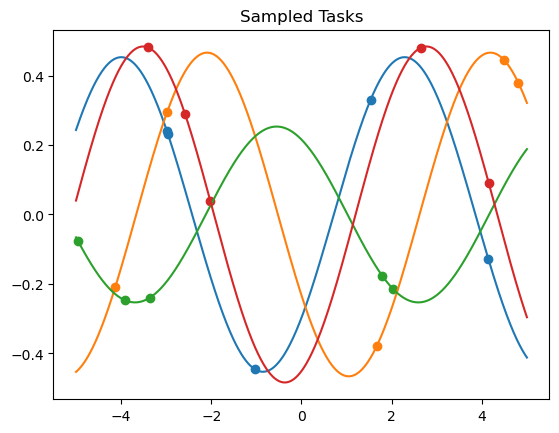

In [7]:
x_dense = torch.linspace(xl, xu, 1000)
batch_y_val_dense = amplitudes[:, None] * torch.sin(x_dense + phases[:, None])

plot_num = 4 # datasets to be visualized
plt.figure()
plt.title("Sampled Tasks")
plt.plot(batch_x_val[:plot_num, :, 0].T, batch_y_val[:plot_num, :, 0].T, 'o')
plt.gca().set_prop_cycle(None)  # Reset the color cycle to ensure the same colors are used
plt.plot(x_dense, batch_y_val_dense[:plot_num].T);

It might be more effective to visualize tasks in different subplots

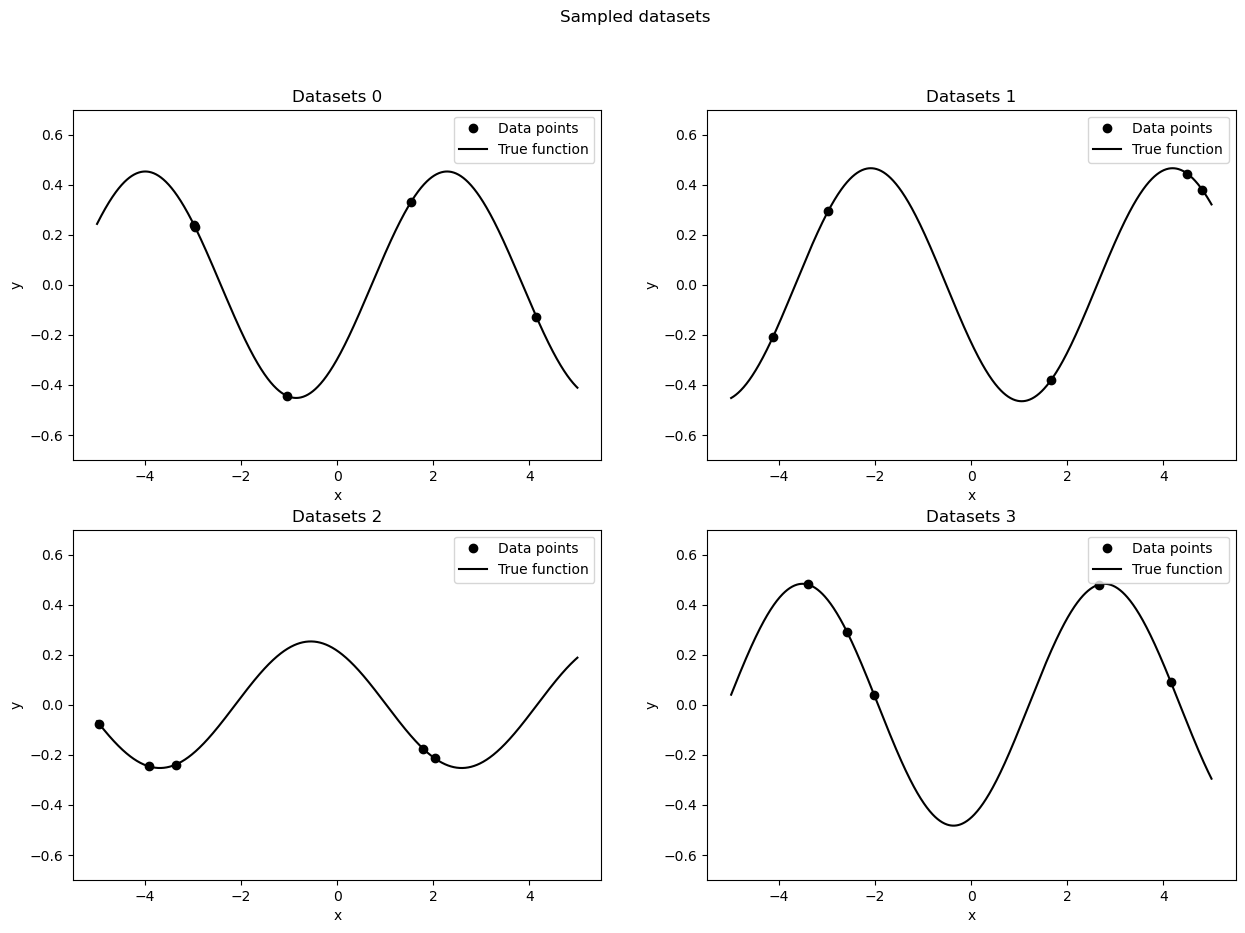

In [8]:
plot_x = 2
plot_y = 2
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
plt.suptitle("Sampled datasets")
for i in range(plot_x):
    for j in range(plot_y):
        idx = i * plot_y + j
        ax[i, j].plot(batch_x_val[idx, :, 0], batch_y_val[idx, :, 0], 'ko', label='Data points')
        ax[i, j].plot(x_dense, batch_y_val_dense[idx], 'k', label='True function')
        ax[i, j].set_title(f"Datasets {idx}")
        ax[i, j].set_xlabel("x")
        ax[i, j].set_ylabel("y")
        ax[i, j].set_ylim(-.7, .7)
        ax[i, j].legend(loc='upper right')


## Standard training from scratch

Let us train distinct models from scratch on each dataset, with standard initialization. Let us first define a reasonable architecture.

Let us first define a reasonable base architecture, which for sure has the capacity to model those simple 1D sinusoid functions

In [9]:
hidden_size = 40

class MLP(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.fc1 = nn.Linear(1, hidden_size)
        self.act1 = nn.Tanh()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.act2 = nn.Tanh()
        self.fc3 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        return x

First let now define a function that trains a single model on single a dataset.

In [10]:
def train_mlp(x, y):

    mlp = MLP(hidden_size)
    opt = torch.optim.AdamW(mlp.parameters(), lr=1e-2)
    losses = []
    for _ in range(5_000):
        opt.zero_grad()
        # Compute the loss
        y_pred = mlp(x)
        loss = torch.mean((y_pred - y)**2)

        # Backpropagation
        loss.backward()
        opt.step()
        losses.append(loss.item())

    return mlp, torch.tensor(losses)

Training of a single model from standard initialization

In [11]:
batch_idx = 4
trained_mlp, losses = train_mlp(batch_x_val[batch_idx], batch_y_val[batch_idx])

Model evaluation

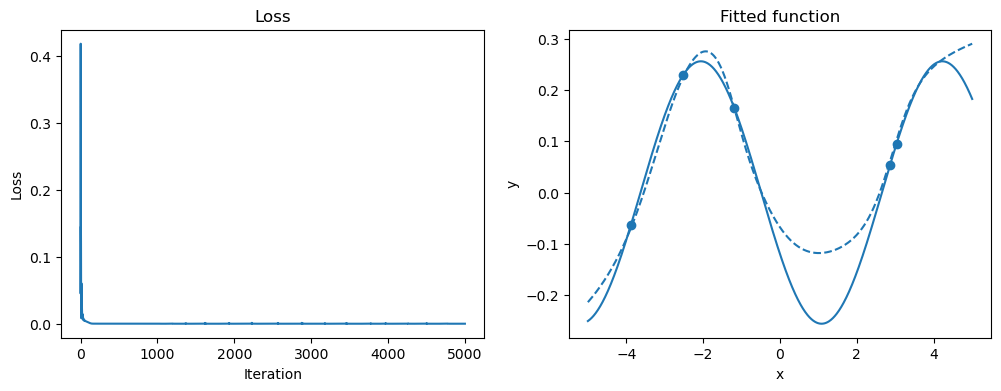

In [12]:
with torch.no_grad():
    y_hat = trained_mlp(x_dense[:, None])

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(losses)
ax[0].set_title('Loss')
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('Loss')
ax[1].plot(x_dense, batch_y_val_dense[batch_idx])
ax[1].set_prop_cycle(None)  # Reset the color cycle to ensure the same colors are used
ax[1].plot(batch_x_val[batch_idx], batch_y_val[batch_idx], 'o')
ax[1].set_prop_cycle(None)  # Reset the color cycle to ensure the same colors are used
ax[1].plot(x_dense, y_hat, '--')
ax[1].set_title('Fitted function')
ax[1].set_xlabel('x')
ax[1].set_ylabel('y');

The MLP fits the data points perfectly, but does not generalize well to the true function fe to the extremely low data regime

## Hypernet implementation

In [13]:
iters = 20_000 # number of outer loop iterations
alpha = 0.1 # learning rate for inner loop
lr = 1e-3 # learning rate for outer loop

Let us sample a batch of datasets as examples to build MAML

In [14]:
batch_x, batch_y, amplitudes, phases = sample_datasets(batch_size=batch_size, K=K*2, return_params=True)

# support set, aka context, training set
batch_x1 = batch_x[:, :K]
batch_y1 = batch_y[:, :K]
# query set, test set
batch_x2 = batch_x[:, K:]
batch_y2 = batch_y[:, K:]

The Hypernet must generate the parameters of the MLP. Let us check how many are they

In [15]:
mlp = MLP(hidden_size)
params_mlp = dict(mlp.named_parameters())
flat_params_mlp = nn.utils.parameters_to_vector(mlp.parameters())
n_params_mlp = flat_params_mlp.shape[0]
n_params_mlp

1761

Let us build a function that reshapes a vector to the mlp parameters of interest

In [16]:
def unflatten_like(flat_tensor: torch.Tensor, model: torch.nn.Module):
    param_shapes = [p.shape for p in model.parameters()]
    param_numels = [p.numel() for p in model.parameters()]
    param_names = [name for name, _ in model.named_parameters()]
    
    split_tensors = torch.split(flat_tensor, param_numels)
    params = {name: t.view(shape) for t, shape, name in zip(split_tensors, param_shapes, param_names)}
    return params

params_mlp_unflattened = unflatten_like(flat_params_mlp, mlp)  # check that the unflattening works

Let us define the Hypernet architecture. We use a DeepSet network here

In [17]:
# PyTorch implementation of DeepSet for generating MLP parameters
class DeepSet(nn.Module):
    def __init__(self, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        # Shared MLP for set elements
        self.fc1 = nn.Linear(2, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        # MLP for aggregated representation
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, output_size)

    def forward(self, x, y):
        z = torch.cat([x, y], dim=-1)
        z = self.fc1(z)
        z = torch.relu(z)
        z = self.fc2(z)
        z = torch.relu(z)
        # Aggregate (sum) over set elements
        z = torch.sum(z, dim=-2)
        z = self.fc3(z)
        z = torch.relu(z)
        z = self.fc4(z) * 0.1  # scale for decent MLP initialization
        
        # Reshape as mlp parameters
        z = unflatten_like(z, mlp)
        return z

In [18]:
# Instantiate the hypernetwork
hypernet = DeepSet(hidden_size=128, output_size=n_params_mlp)

In [19]:
# Hypernet usage: dataset in, MLP parameters out
params_mlp_ = hypernet(batch_x1[0], batch_y1[0])  # Apply the hypernetwork to get the parameters for the MLP

In [20]:
# We will need to make functional calls to the hypernetwork
params_hypernet = dict(hypernet.named_parameters())
params_mlp_ = functional_call(hypernet, params_hypernet, args=(batch_x1[0], batch_y1[0]))  # Get the parameters for the MLP

Let us test the regression loss on a single dataset

In [21]:
# Function that trains a single model
def loss_fn(p, x, y):
    y_hat = functional_call(mlp, p, x)
    loss = torch.mean((y - y_hat) ** 2)
    return loss

loss_fn(params_mlp, batch_x1[0], batch_y1[0])

tensor(0.1751, grad_fn=<MeanBackward0>)

Let us define and test the Hypernet loss for a single dataset

In [22]:
def hypernet_loss(ph, x1, y1, x2, y2):

    # Generate the weights using the hypernetwork on the support set
    pm = functional_call(hypernet, ph, args=(x1, y1))
    # Compute the loss on the query set
    return loss_fn(pm, x2, y2)  # Loss for the second task

hypernet_loss(params_hypernet, batch_x1[0], batch_y1[0], batch_x2[0], batch_y2[0])

tensor(0.0350, grad_fn=<MeanBackward0>)

Let us vectorize the Hypernet loss with ``vmap``

In [23]:
def batched_hypernet_loss(p, x1_b, y1_b, x2_b, y2_b):
    hypernet_loss_cfg = partial(hypernet_loss, p) # fix first argument
    hypernet_loss_batch = vmap(hypernet_loss_cfg) # vmap over the rest
    batch_losses = hypernet_loss_batch(x1_b, y1_b, x2_b, y2_b)
    return torch.mean(batch_losses)

batched_hypernet_loss(params_hypernet, batch_x1, batch_y1, batch_x2, batch_y2)

tensor(0.0645, grad_fn=<MeanBackward0>)

Let us set-up the MAML meta-optimization

In [24]:
opt = torch.optim.Adam(params_hypernet.values(), lr=lr)
losses = []

for i in (pbar :=tqdm(range(iters))):
    batch_x, batch_y = sample_datasets(batch_size=batch_size, K=2*K)
    batch_x1 = batch_x[:, :K]
    batch_y1 = batch_y[:, :K]
    batch_x2 = batch_x[:, K:]
    batch_y2 = batch_y[:, K:]


    opt.zero_grad()
    loss = batched_hypernet_loss(params_hypernet, batch_x1, batch_y1, batch_x2, batch_y2)
    loss.backward()
    opt.step()
    losses.append(loss.item())
    if i % 100 == 0:
        pbar.set_postfix(loss=loss.item())

100%|██████████| 20000/20000 [00:45<00:00, 443.31it/s, loss=0.00339]


Text(0, 0.5, 'Loss')

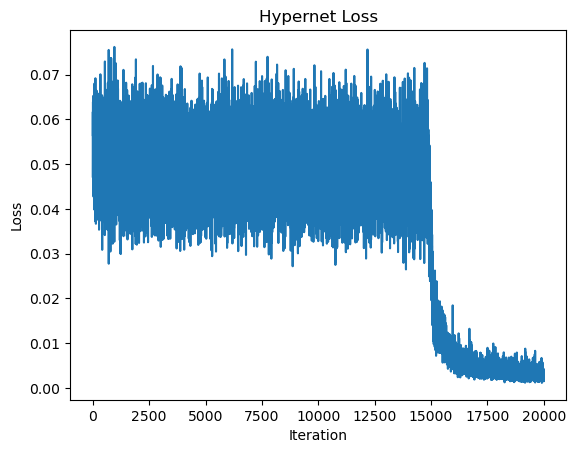

In [25]:
plt.figure()
plt.plot(losses)
plt.title("Hypernet Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")

## Compare Hypernet training vs. standard training from scratch

For a particular dataset, let us compare standard training with GD starting from MAML initialization

In [26]:
batch_idx = 10

Standard training from scratch (i.e., default initialization, AdamW until convergence)

In [27]:
trained_mlp, losses = train_mlp(batch_x_val[batch_idx], batch_y_val[batch_idx])
with torch.no_grad():
    y_hat = trained_mlp(x_dense[:, None])

Instead of training with a gradient-based algorithm, use the Hypernet to generate the parameters for the MLP

In [28]:
#trained_params_maml = inner_update(params_maml, batch_x_val[batch_idx], batch_y_val[batch_idx])
params_mlp_hn = functional_call(hypernet, params_hypernet, args=(batch_x_val[batch_idx], batch_y_val[batch_idx]))

with torch.no_grad():
    y_hat_hn = functional_call(mlp, params_mlp_hn, x_dense[:, None])

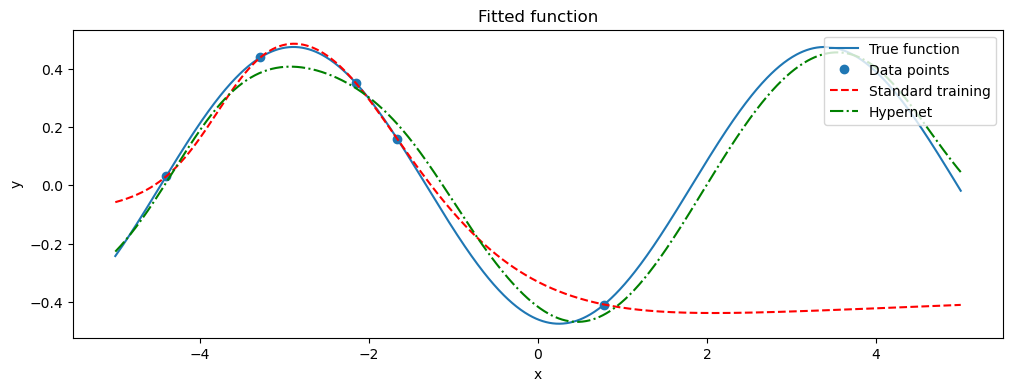

In [29]:
plt.figure(figsize=(12, 4))
ax = plt.gca()
ax.plot(x_dense, batch_y_val_dense[batch_idx], label='True function')
ax.set_prop_cycle(None)  # Reset the color cycle to ensure the same colors are used
ax.plot(batch_x_val[batch_idx], batch_y_val[batch_idx], 'o', label='Data points')
ax.plot(x_dense, y_hat, 'r--', label='Standard training')
ax.plot(x_dense, y_hat_hn, 'g-.', label='Hypernet')
ax.set_title('Fitted function')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.legend(loc='upper right');

The Hypernet generalizes much better!